In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
IMG_SIZE = 192

#Declare ImageDataGenerator with rescaling and hflips
datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = 1,validation_split = 0.2)

In [3]:
train_data = datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    seed = 13,
    subset = 'training'
)
val_data = datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    seed = 13,
    subset = 'validation'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [4]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
Weights = '../input/mobilenetv2-imagenet-weight/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5'
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = Weights)

In [5]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [6]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(29,activation = 'softmax')
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [7]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 29)                37149     
Total params: 2,295,133
Trainable params: 37,149
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_data, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 101ms/step - loss: 3.8513 - accuracy: 0.0156
initial loss: 3.85
initial accuracy: 0.02


In [9]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data)

Epoch 1/10
2175/2175 [==============================] - 306s 141ms/step - loss: 0.2885 - accuracy: 0.9405 - val_loss: 0.5927 - val_accuracy: 0.8248
Epoch 2/10
2175/2175 [==============================] - 190s 88ms/step - loss: 0.0466 - accuracy: 0.9918 - val_loss: 0.5981 - val_accuracy: 0.8355
Epoch 3/10
2175/2175 [==============================] - 191s 88ms/step - loss: 0.0255 - accuracy: 0.9951 - val_loss: 0.5718 - val_accuracy: 0.8375
Epoch 4/10
2175/2175 [==============================] - 192s 88ms/step - loss: 0.0153 - accuracy: 0.9975 - val_loss: 0.6747 - val_accuracy: 0.8294
Epoch 5/10
2175/2175 [==============================] - 191s 88ms/step - loss: 0.0112 - accuracy: 0.9978 - val_loss: 0.6533 - val_accuracy: 0.8395
Epoch 6/10
2175/2175 [==============================] - 195s 89ms/step - loss: 0.0087 - accuracy: 0.9983 - val_loss: 0.6678 - val_accuracy: 0.8401
Epoch 7/10
2175/2175 [==============================] - 194s 89ms/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 

In [10]:
model.save('mobilenetv2_190_kaggle.h5')

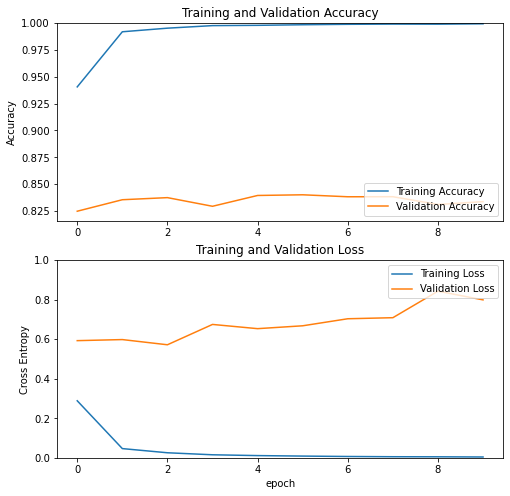

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()